# Points Project

Gabi Capone

7 October 2023

In [2]:
import geopandas 

import matplotlib.pyplot as plt

greenspace = geopandas.read_file("https://arcgis.atlantaregional.com/arcgis/rest/services/OpenData/FeatureServer/123/query?outFields=*&where=1%3D1&f=geojson")
atl = geopandas.read_file("https://arcgis.atlantaregional.com/arcgis/rest/services/OpenData/FeatureServer/197/query?outFields=*&where=1%3D1&f=geojson")

This project centers around greenspaces (gardens, farms, and orchards) in the City of Atlanta as of 2021. 

Data regarding greenspaces and Atlanta neighborhoods comes from the Georgia Association of Regional Commissions (https://opendata.atlantaregional.com/datasets/GARC::gardens-farms-and-orchards/explore?location=33.417628%2C-83.576754%2C8.55), (https://opendata.atlantaregional.com/datasets/GARC::neighborhood-planning-units-2015/about). 

I find the distribution of greenspace in an urban setting interesting as well as the concept of urban sustainability. 

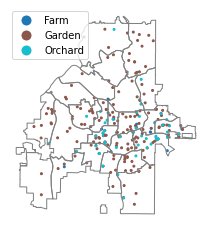

In [3]:
import geopandas

greenspace = greenspace.to_crs('EPSG:3857')

atl = atl.to_crs(greenspace.crs)

greenspace = greenspace.sjoin(atl)

axis = greenspace.plot("Type", legend=True, markersize=4)

atl.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()

plt.show()

In [4]:
greenspace.info()
atl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 250 entries, 1 to 647
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   OBJECTID_1              250 non-null    int64   
 1   Name                    250 non-null    object  
 2   County                  231 non-null    object  
 3   Address_Li              249 non-null    object  
 4   City                    232 non-null    object  
 5   ZIP                     209 non-null    float64 
 6   Source                  231 non-null    object  
 7   GlobalID_left           250 non-null    object  
 8   last_edited_date_left   250 non-null    int64   
 9   Subtype                 173 non-null    object  
 10  Type                    248 non-null    object  
 11  geometry                250 non-null    geometry
 12  index_right             250 non-null    int64   
 13  OBJECTID                250 non-null    int64   
 14  NPU               

The bar chart below displays the percent of greenspaces in the Atlanta divided by each type of greenspace. It appears that gardens make up an overwhelming amount of the types of greenspace in Atlanta, followed by orchards and then farms. 


<BarContainer object of 3 artists>

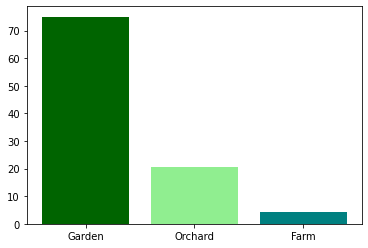

In [4]:
type_pct =greenspace["Type"].value_counts() / greenspace["Type"].count() * 100

plt.bar(type_pct.index, type_pct, color=["darkgreen", "lightgreen", "teal"])

The table below displays the breakdown of subtype among Atlanta greenspaces. Of the subtypes, "Community" and "School" make up the majority, having the values of 45% and 30%.

In [5]:
greenspace["Subtype"].value_counts() / greenspace["Subtype"].count() * 100

Community           45.086705
School              30.057803
Unclassified        17.341040
Education            4.046243
Urban Farm           1.156069
Community            0.578035
Orchard              0.578035
Community Garden     0.578035
Donation             0.578035
Name: Subtype, dtype: float64

For gardens, orchards, and farms in Atlanta, there are notable clustering to the west and east of the city center in NPUs T, O, and W.

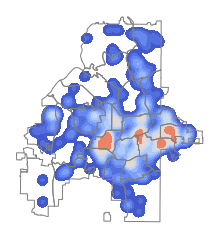

In [6]:
import seaborn

axis = seaborn.kdeplot(x = greenspace.centroid.x, y = greenspace.centroid.y,
        fill=True, gridsize=100, bw_adjust=0.3, cmap="coolwarm")

atl.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()

plt.show()


There is a notable concentration of greenspace in NPU W and its surrounding neighborhood units.


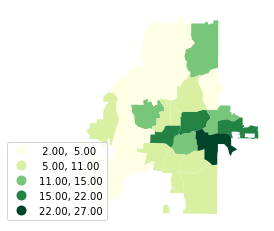

In [7]:
greenspace["Count"] = 1

greenspace =greenspace.groupby("NPU")["Count"].count()

greenspace =greenspace.reset_index()

greenspace = atl.merge(greenspace)

axis = greenspace.plot("Count", scheme="naturalbreaks", cmap="YlGn", 
		legend=True, legend_kwds={"bbox_to_anchor":(0.2, 0.4)})

axis.set_axis_off()

plt.show()

As the global Moran's I for this dataset is 0.28 there is significant autocorrelation of greenspaces.

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])


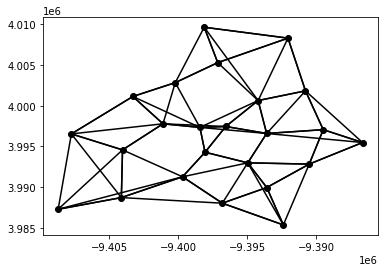

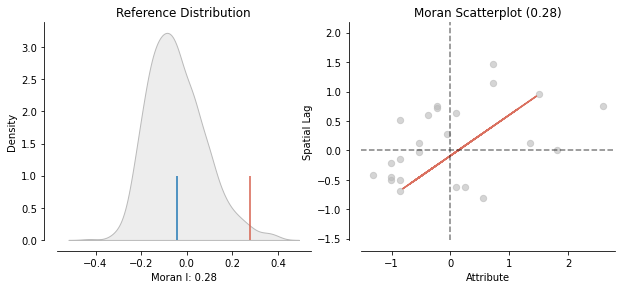

In [8]:
import esda.moran

import splot.esda

import matplotlib.pyplot as plt

import pysal.lib

import pysal.model


greenspace["NPU"] = range(greenspace.shape[0])

atl_weights = pysal.lib.weights.KNN.from_dataframe(greenspace, ids="NPU", k=4)

atl_weights.plot(gdf=greenspace, indexed_on="NPU")

plt.show()


greenspace["Count"] = greenspace["Count"].fillna(0)

moran = esda.moran.Moran(greenspace["Count"], atl_weights)
splot.esda.plot_moran(moran, zstandard=True, figsize=(10,4))

plt.show()




There are several hot spots located to the south and east of Atlanta's city center (NPUs V, W, N, and O). NPU B is a high outlier, located north east of downtown. 

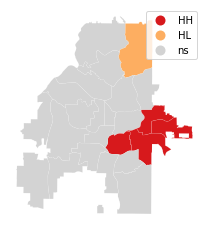

In [9]:
moran_local = esda.moran.Moran_Local(greenspace["Count"], atl_weights)

splot.esda.lisa_cluster(moran_local, greenspace[["Count", "geometry"]])

plt.show()